## Asignment: Computer vison course
- Alumno 1: Daniel Carmona Pedrajas
- Alumno 2: Joel Pardo Ferrera

The goals of this assignment are:
+ Develop proficiency in using Tensorflow/Keras for training neural nets (NNs).
+ Put in practice Unit 4 knowledge to optimize the parameters and architecture of a feed-forward Neural Net (ffNN), in the context of a computer vision problem.
+ Use NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (cNN).

Follow the link above to download the classification benchmark termed “xview_recognition”: [https://drive.upm.es/s/c4gfDOOwWfPdm0z](https://drive.upm.es/s/c4gfDOOwWfPdm0z")

In [1]:
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
tf.device('/device:GPU.0')
tf.__version__

'2.10.0'

In [2]:
IMAGES_PATH = "../../../xview_recognition/xview_recognition/"
MODELS_PATH = "../Models/"
MODELS_HISTORY_PATH = f"{MODELS_PATH}models_history.csv"
MODELS_IMAGES_PATH = f"{MODELS_PATH}ModelsImages/"
RESULTS_IMAGES_PATH = "../ResultsImages/"

In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {13: 'CARGO_PLANE', 
              15: 'HELICOPTER', 
              18: 'SMALL_CAR', 
              19: 'BUS', 
              23: 'TRUCK', 
              41: 'MOTORBOAT', 
              47: 'FISHING_VESSEL', 
              60: 'DUMP_TRUCK', 
              64: 'EXCAVATOR', 
              73: 'BUILDING',
              86: 'STORAGE_TANK', 
              91: 'SHIPPING_CONTAINER'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories, model_name, normalize=False):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)
    fig.savefig(f"{RESULTS_IMAGES_PATH}cm_{model_name}.png")

## Training
Design and train a ffNN to deal with the xview_recognition classification task

In [7]:
import json
# Load database
json_file = f'{IMAGES_PATH}xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np
counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(IMAGES_PATH + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    if counts[obj.category] >= 5000:
        continue
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
    
print(counts)

{'CARGO_PLANE': 628, 'HELICOPTER': 49, 'SMALL_CAR': 5000, 'BUS': 5000, 'TRUCK': 5000, 'MOTORBOAT': 1231, 'FISHING_VESSEL': 736, 'DUMP_TRUCK': 1238, 'EXCAVATOR': 706, 'BUILDING': 5000, 'STORAGE_TANK': 1462, 'SHIPPING_CONTAINER': 1522}


In [9]:
from sklearn.model_selection import train_test_split
anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.initializers import HeUniform, HeNormal
from keras.regularizers import L1

exp = "-4-6-1"
ACTIVATION = "relu"
DROPOUT = "0.2"
REGULARIZATION = "L1 0.01"
INITIALIZER = "HeUniform"
BATCH_NORMALIZATION = "Yes"

def initial_model1():
    print('Load model')
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    model.add(Activation(ACTIVATION))
    model.add(Dropout(0.2))
    model.add(Dense(len(categories)))
    model.add(Activation('softmax'))
    model_name = f"ir_12{exp}"
    return model, model_name

def ffnn_architecture2():
    print('Load model')
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [256, 128, 64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons))
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    model.add(Dense(len(categories)))
    model.add(Activation('softmax'))
    model_name = f"ir_256_128_64_32{exp}"
    return model, model_name

def ffnn_architecture3():
    print("Load model")
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [512, 128, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons))
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
    model.add(Dense(len(categories)))
    model.add(Activation('softmax'))
    model_name = f"ir_512_128_32{exp}"
    return model, model_name


def ffnn_architecture4():
    print("Load model")
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))
    n_hidden = [64, 32]
    for neurons in n_hidden:
        model.add(Dense(neurons, 
                        kernel_initializer=HeUniform(seed=None),
                        kernel_regularizer=L1(0.01)))
        model.add(BatchNormalization())
        model.add(Activation(ACTIVATION))
        model.add(Dropout(0.2))
                        
    model.add(Dense(len(categories), 
                    kernel_initializer=HeUniform(seed=None),
                    kernel_regularizer=L1(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model_name = f"ir_64_32{exp}"
    return model, model_name

In [11]:
# Load architecture
model, model_name = ffnn_architecture4()
model.summary()
plot_model(model, to_file=f"{MODELS_IMAGES_PATH}{model_name}.png", show_shapes=True, show_layer_names=True)

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 64)                9633856   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                             

In [12]:
# Learning rate is changed to 0.001
from keras.optimizers import Adam
OPTIMIZER_NAME = "Adam 0.9 0.999"
LEARNING_RATE = 0.1
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Callbacks
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_checkpoint = ModelCheckpoint(f'{MODELS_PATH}{model_name}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=20, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]
CALLBACKS_NAMES = "reducelr 5 0.1 - early_stop 20"

In [14]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
BATCH_SIZE = 64
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

In [15]:
import math
import numpy as np
import time

print('Training model')
N_EPOCHS = 50
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

start_time = time.perf_counter()

h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=N_EPOCHS, callbacks=callbacks, verbose=1)

end_time = time.perf_counter()
TRAINING_TIME = round(end_time - start_time)

# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model


C:\Users\dcarm\AppData\Local\Temp\ipykernel_7104\3526262076.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=N_EPOCHS, callbacks=callbacks, verbose=1)


Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 1247.3057 - accuracy: 0.1923
Epoch 1: val_accuracy improved from -inf to 0.17223, saving model to ../Models\ir_64_32-4-6-1.hdf5
388/388 [==============================] - 227s 580ms/step - loss: 1247.3057 - accuracy: 0.1923 - val_loss: 1078.1267 - val_accuracy: 0.1722 - lr: 0.1000
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 1088.1754 - accuracy: 0.1918
Epoch 2: val_accuracy improved from 0.17223 to 0.18927, saving model to ../Models\ir_64_32-4-6-1.hdf5
388/388 [==============================] - 187s 483ms/step - loss: 1088.1754 - accuracy: 0.1918 - val_loss: 1111.4473 - val_accuracy: 0.1893 - lr: 0.1000
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 1083.0112 - accuracy: 0.1909
Epoch 3: val_accuracy did not improve from 0.18927
388/388 [==============================] - 186s 481ms/step - loss: 1083.0112 - accuracy: 0.1909 - val_loss: 1062.2871 - val_accuracy: 0.1421 - 

Epoch 27/50
388/388 [==============================] - ETA: 0s - loss: 3.9721 - accuracy: 0.2842
Epoch 27: val_accuracy did not improve from 0.29623

Epoch 27: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
388/388 [==============================] - 188s 485ms/step - loss: 3.9721 - accuracy: 0.2842 - val_loss: 4.0918 - val_accuracy: 0.1914 - lr: 1.0000e-04
Epoch 28/50
388/388 [==============================] - ETA: 0s - loss: 2.4675 - accuracy: 0.3117
Epoch 28: val_accuracy did not improve from 0.29623
388/388 [==============================] - 188s 486ms/step - loss: 2.4675 - accuracy: 0.3117 - val_loss: 2.4886 - val_accuracy: 0.2502 - lr: 1.0000e-05
Epoch 29/50
388/388 [==============================] - ETA: 0s - loss: 2.4102 - accuracy: 0.3172
Epoch 29: val_accuracy did not improve from 0.29623
388/388 [==============================] - 189s 487ms/step - loss: 2.4102 - accuracy: 0.3172 - val_loss: 2.4712 - val_accuracy: 0.2495 - lr: 1.0000e-05
Epoch 30/50
388/388

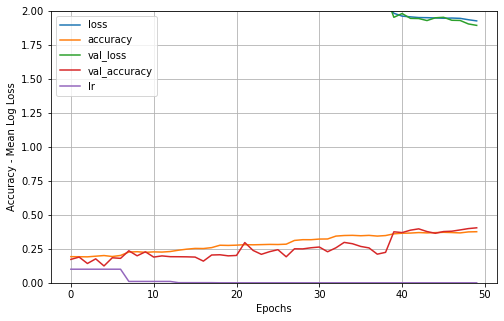

In [16]:
import pandas as pd
results=pd.DataFrame(h.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig(f"{RESULTS_IMAGES_PATH}tr_{model_name}.png")
plt.show()

In [17]:
h.history

{'loss': [1247.3056640625,
  1088.1754150390625,
  1083.01123046875,
  1082.5067138671875,
  1084.32373046875,
  1084.289306640625,
  1084.19677734375,
  143.6250457763672,
  117.6361312866211,
  115.95712280273438,
  116.61392974853516,
  116.08439636230469,
  115.87291717529297,
  17.202083587646484,
  14.55060863494873,
  14.68881893157959,
  14.750844955444336,
  14.761655807495117,
  4.26151180267334,
  3.964885950088501,
  3.935206174850464,
  3.924842596054077,
  3.9427638053894043,
  3.9424760341644287,
  3.9186747074127197,
  3.938300132751465,
  3.9720940589904785,
  2.4674811363220215,
  2.4101603031158447,
  2.3964343070983887,
  2.3896732330322266,
  2.3855302333831787,
  2.077352285385132,
  2.0529446601867676,
  2.0504679679870605,
  2.0496490001678467,
  2.0484964847564697,
  2.051644802093506,
  2.047636032104492,
  1.9833658933639526,
  1.9621466398239136,
  1.9570229053497314,
  1.9517968893051147,
  1.950934648513794,
  1.9487675428390503,
  1.9465432167053223,
  1.

In [18]:
import json
# Load database
json_file = f'{IMAGES_PATH}xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [19]:
import numpy as np
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(IMAGES_PATH + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [20]:
import numpy as np
import keras
model = keras.models.load_model(f'{MODELS_PATH}{model_name}.hdf5')
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 89ms/step


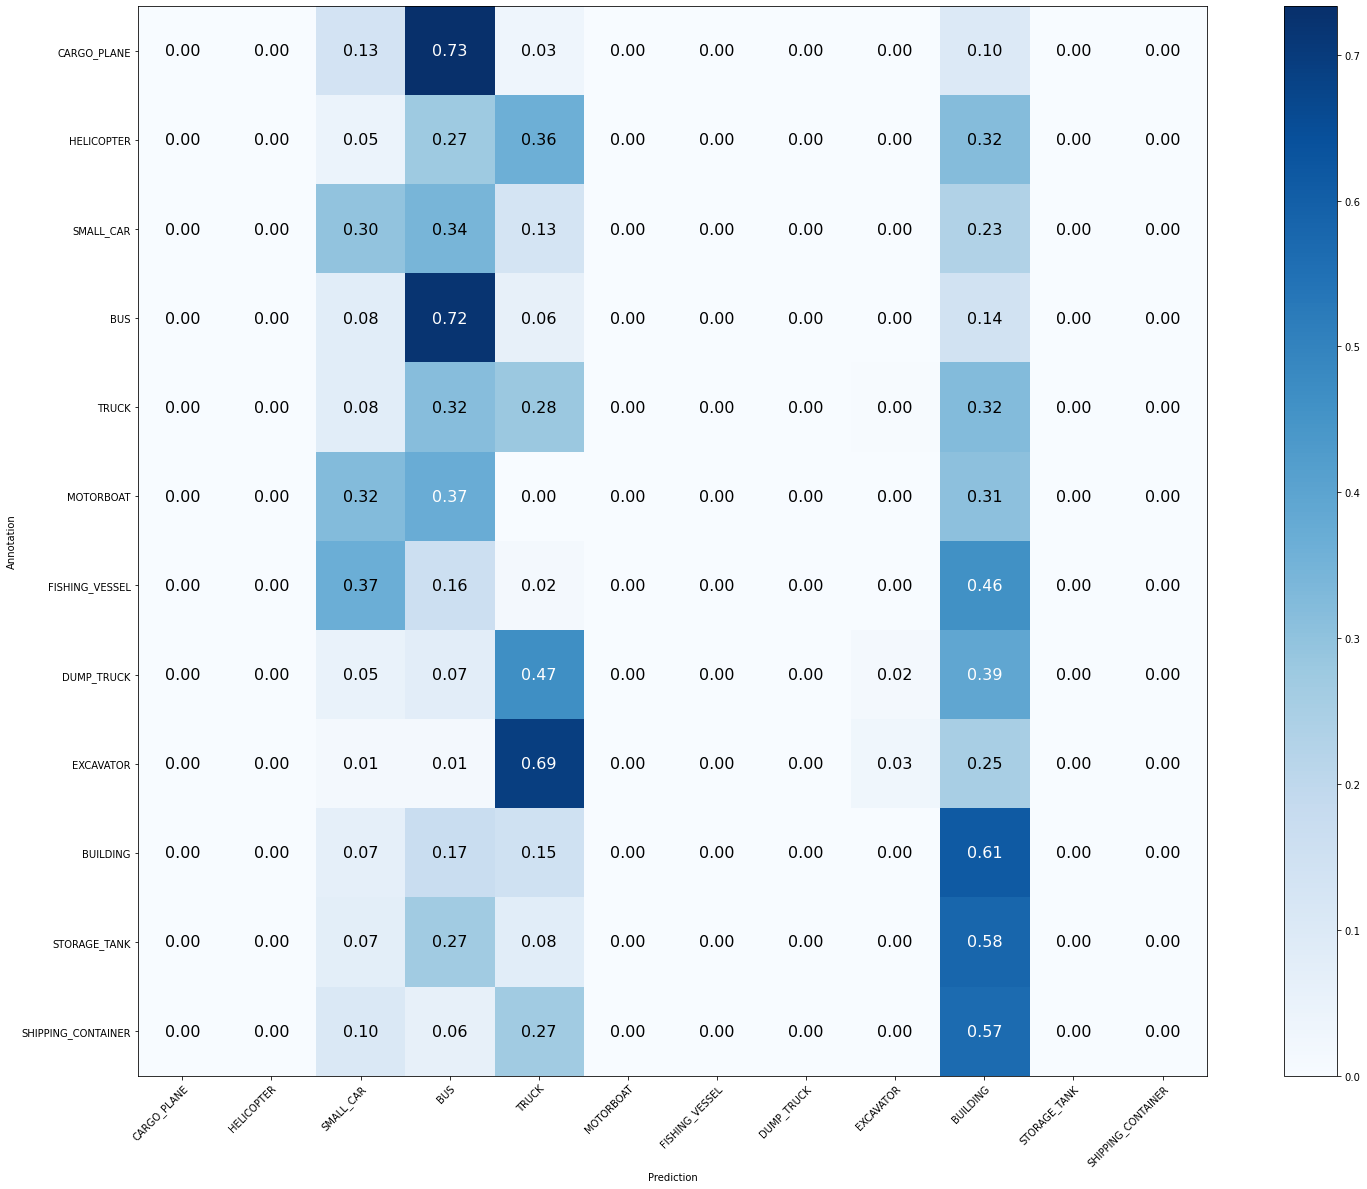

In [21]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories, model_name, normalize=True)

In [22]:
import numpy as np
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)

MEAN_ACCURACY = (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100)
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
MEAN_RECALL = (acc.mean() * 100)
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
MEAN_PRECISION = (acc.mean() * 100)

print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 49.344%
Mean Recall: 16.145%
Mean Precision: 15.037%
> CARGO_PLANE: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> SMALL_CAR: Recall: 29.588% Precision: 66.323% Specificity: 93.129% Dice: 40.921%
> BUS: Recall: 72.066% Precision: 2.473% Specificity: 76.823% Dice: 4.782%
> TRUCK: Recall: 27.889% Precision: 5.567% Specificity: 85.665% Dice: 9.281%
> MOTORBOAT: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> FISHING_VESSEL: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> DUMP_TRUCK: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> EXCAVATOR: Recall: 2.857% Precision: 25.000% Specificity: 99.977% Dice: 5.128%
> BUILDING: Recall: 61.345% Precision: 81.086% Specificity: 75.634% Dice: 69.848%
> STORAGE_TANK: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> SHIPPING_CONTAINER: Recall: 0.000%

## Save results

In [23]:
history_df = pd.read_csv(MODELS_HISTORY_PATH, index_col = 0)

In [24]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'optimizer',
    'activation',
    'batch_size',
    'callbacks',
    'regularization',
    'initializer',
    'dropout',
    'batch_normalization',
    'mean_accuracy',
    'mean_recall',
    'mean_precision',
    'training_time'
]

new_history = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    OPTIMIZER_NAME,
    ACTIVATION,
    BATCH_SIZE,
    CALLBACKS_NAMES,
    REGULARIZATION,
    INITIALIZER,
    DROPOUT,
    BATCH_NORMALIZATION,
    MEAN_ACCURACY,
    MEAN_RECALL,
    MEAN_PRECISION,
    TRAINING_TIME
    ]]

new_history_df = pd.DataFrame(new_history, columns=COLUMNS)

In [25]:
concatenation = pd.concat([history_df, new_history_df], ignore_index=True)
concatenation.to_csv(MODELS_HISTORY_PATH)

In [26]:
concatenation.tail()

,model_name,epochs,learning_rate,optimizer,activation,batch_size,callbacks,regularization,initializer,dropout,batch_normalization,mean_accuracy,mean_recall,mean_precision,training_time
8,ir_64_32-4-2-1,50,0.1,Adam 0.9 0.999,relu,64,reducelr 10 0.1 - early_stop 10,No,No,0.2,No,0.808856,8.333333,0.067405,2742
9,ir_64_32-4-3-1,50,0.1,Adam 0.9 0.999,relu,64,reducelr 10 0.1 - early_stop 20,No,No,0.2,Yes,36.087113,25.880631,20.463209,9634
10,ir_64_32-4-4-1,50,0.1,Adam 0.9 0.999,relu,64,reducelr 5 0.1 - early_stop 20,No,HeUniform,0.2,Yes,41.994038,28.931194,18.828217,9670
11,ir_64_32-4-5-1,50,0.1,Adam 0.9 0.999,relu,64,reducelr 5 0.1 - early_stop 20,No,HeNormal,0.2,Yes,40.647844,29.650857,18.978194,9505
12,ir_64_32-4-6-1,50,0.1,Adam 0.9 0.999,relu,64,reducelr 5 0.1 - early_stop 20,L1 0.01,HeUniform,0.2,Yes,49.343991,16.145427,15.037402,9457
